# Statistical Methods for Studying Population of Connectomes

This live demo will demonstrate usage of **[GraSPy](https://neurodata.io/graspy)** and its embedding methods that can be used for subsequenct inference tasks, such as connectome clustering/classification and vertex clustering. As reference, the slides are located [here]().

Omnibus embedding (omni) and Multiple Adjacency Spectral Embedding (mase)

In [1]:
from pathlib import Path
import numpy as np

### Loading the data

In [2]:
p = Path('./data/')
files = sorted(p.glob('*npy'))

graphs = [np.load(f) for f in files]
labels = np.array([f.parts[1].split("_")[0] for f in files])

### Preprocessing the data

Pass-to-ranks (ptr) is a method of ranking all the edge weights and normalizing by a constant (i.e. number of edges within graph). PTR can provide robustness to extremely large edge weights, which may be a concern when using connectomes derived from diffusion tractography.

In [3]:
from graspy.utils import pass_to_ranks

graphs_ptr = [pass_to_ranks(g) for g in graphs]

## Connectome Clustering using Omnibus Embedding (omni)

The steps are outlined as below:

1. Learn the embeddings for all connectomes via omni.
2. Compute a dissimilarity matrix via a Euclidean distance.
3. Embed the dissimilarity matrix using classical MDS (cMDS) to obtain a feature vector for each connectome.
3. Use gaussian mixture models to cluster the connectomes.

In [4]:
from graspy.embed import OmnibusEmbed, ClassicalMDS

In [5]:
omni = OmnibusEmbed(check_lcc=False)
omni_embeddings = omni.fit_transform(graphs_ptr)

cmds = ClassicalMDS()
connectome_features = cmds.fit_transform(omni_embeddings)

### Visualize intermediate and final results

1. Heatmap shows the dissimilarity matrix from step (2).
  - more white means low dissimilarity (or high similarity)
  - more red means high dissimilarity (or low similarity)
  
2. Pairplot shows the embeddings of the dissimilarity matrix and colored by true subject labels

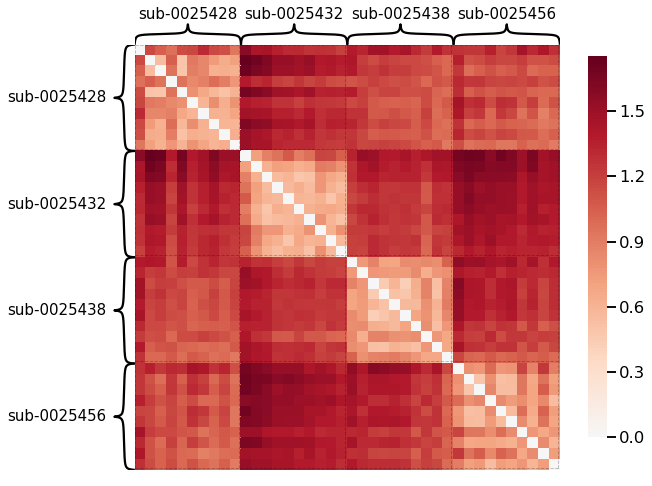

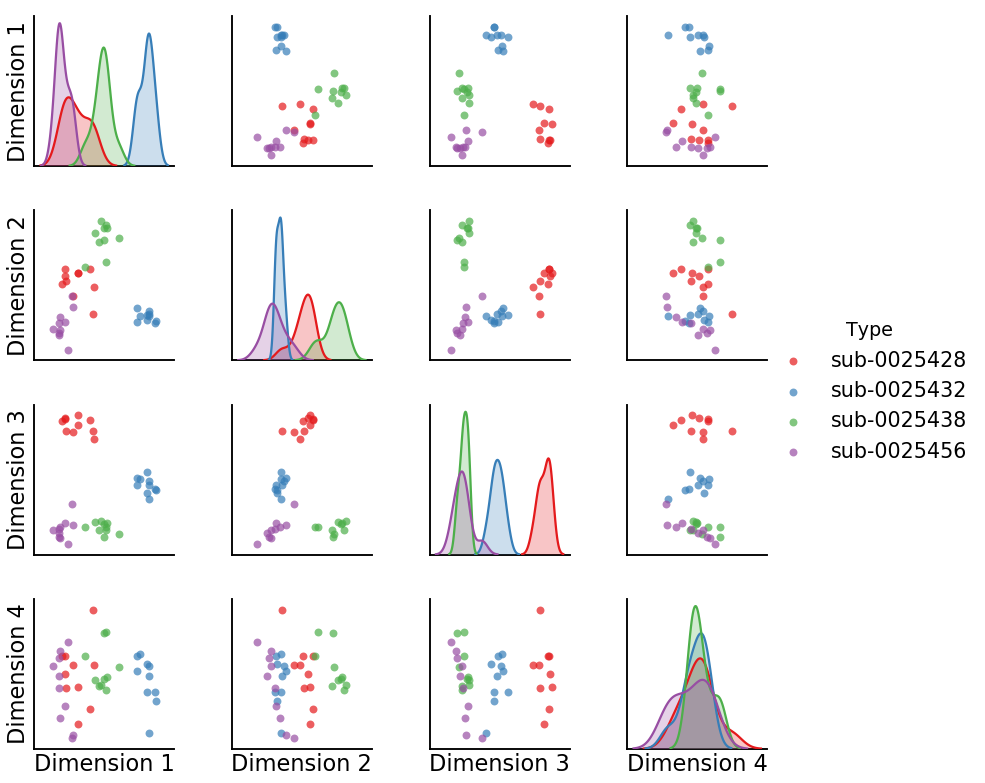

In [6]:
from graspy.plot import pairplot, heatmap
%matplotlib inline

heatmap(cmds.dissimilarity_matrix_, inner_hier_labels=labels, hier_label_fontsize=15)

pairplot(connectome_features, labels, height=3, size=250, font_scale=1.25)

### Clustering the connectome features

Suppose we don't know the true labels, that is we don't know which connectome belongs to which subject. We can cluster the connectome features to see what groups result. Ideally, we should have 3 clusters, each cluster belonging to a subject.

But we can evaluate the "goodness" of clustering by comparing how the connectomes are clustered to actual subject labels. We compute the [adjusted rand index (ARI)](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html) to see how good our clusters are.

In [7]:
from graspy.cluster import GaussianCluster

# Sweep over 1 to 10 clusters
gclust = GaussianCluster(10)
gclust.fit(connectome_features, labels)

GaussianCluster(covariance_type=array(['full'], dtype='<U4'),
        max_components=None, min_components=10, random_state=None)

In [8]:
gclust.ari_

,full
1,0.000000
2,0.315789
3,0.697674
4,1.000000
5,0.920938
6,0.821918
7,0.712223
8,0.687865
9,0.562800
10,0.637450


## Connectome Classification using Multiple Adjacency Spectral Embedding (MASE)

In [9]:
from graspy.embed import MultipleASE

mase = MultipleASE()
mase.fit(graphs_ptr)

MultipleASE(algorithm='randomized', n_components=None, n_elbows=2, n_iter=5,
      unscaled=True)

In [10]:
connectome_features = mase.scores_.reshape(40, -1)[:, :28]

## Classify via 1-NN

In [11]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import LeaveOneOut

loo = LeaveOneOut()

predictions = []
for train_idx, test_idx in loo.split(connectome_features):
    train_X = connectome_features[train_idx]
    train_y = labels[train_idx]
    
    test_X = connectome_features[test_idx]
    test_y = labels[test_idx]
    
    knn = KNeighborsClassifier(1)
    knn.fit(train_X, train_y)
    
    predictions.append(knn.predict(test_X)[0])

print("Classification Accuracy: {}".format((np.array(predictions) == labels).sum()/labels.size))

Classification Accuracy: 0.975


## Vertex Data Visualization via MASE

We will visualize the common latent position matrix from MASE.

Plots are labelled by:

1. Left and right hemispheres
2. 4 main lobes

In [12]:
vertex_features = mase.latent_left_

In [13]:
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

# Loading labels for each node
import pandas as pd

df = pd.read_csv('./data/labels.csv')
hemispheres = df['hemisphere'].values
lobe = df['lobe'].values

In [14]:
def plot_3d(data, labels, dim1=0, dim2=1, dim3=2):
    traces = []

    for label in np.unique(labels):
        data = vertex_features[labels == label]
        traces.append(
            go.Scatter3d(
                x=data[:, dim1],
                y=data[:, dim2],
                z=data[:, dim3],
                name=label,
                mode='markers',
            ))

    fig = go.Figure(data=traces)

    iplot(fig)

In [15]:
# Plot by hemispheres
plot_3d(vertex_features, hemispheres)

In [16]:
# Plot by hemispheres
plot_3d(vertex_features, lobe)